In [11]:
import cv2 as cv
import cupy as cp
import numpy as np

import matplotlib.pyplot as plt

## Vectorized Operation

<img src="..\documents\vectorization-2d-strategy.png" width="450"/>

In [12]:
def kernels_shapes(N, kernel):
    """calculates the kernel shape used for sliding_window_view function and the total elements
    of the kernel used for reshaping function

    Args:
        N (tuple): the shape tuple of the image
        kernel (np.ndarray): the kernel(s) to calculate the required shapes

    Returns:
        tuple: the tuple shape for using in sliding_window_view
        total: the calculation of the total items in the kernel(s)
    """
    k = kernel.shape
    n = len(N) - len(k)
    return k + tuple([1] * n), np.prod(np.asarray(k))

def apply_2d_filter(image, kernels=(), padding=1):
    """Shapes the image into sliding windows and that result into a transposed matrix where rows
    are the contents of each window and columns are the windows calculated from the sliding_window_view.
    A matrix multiplication is performed for calculating the convolutions.

    Args:
        image (np.ndarray): the image to calculate the operator
        kernels (tuple, optional): the kernel(s) to operate on the image. Defaults to ().
        padding (int, optional): size of the borders added to the image. Defaults to 1.

    Returns:
        np.ndarray: A tensor with the images one per kernel (img, H, W)
    """
    assert image is not None, "Image must not be None"
    assert len(kernels) > 0, "Must be at least one kernel"
    assert all(len(i) == len(kernels[0]) for i in kernels), "Kernels must be of the same size"
    
    k, kdim = kernels_shapes(image.shape, kernels[0])
    
    # Adds a pad to the borders of each image
    img = np.pad(image.astype(np.float32), pad_width=(padding,padding))
    
    # Shapes the kernels in a single matrix
    kernels = [ kl.reshape(kdim) for kl in kernels ]
    kstack = np.vstack(kernels).astype(np.float32)

    # Creates the sliding windows from the image with k size
    views = np.lib.stride_tricks.sliding_window_view(img, k)
    N = views.shape

    # reshape the view to form a matrix
    stack = np.reshape(views, (N[0] * N[1], kdim)).T
    
    # perform the matrix multiplication
    map = kstack @ stack
    
    # convert back the image from flatten to 2 dims
    res = map.reshape((map.shape[0], N[0], N[1]))
    
    return res

In [13]:
def prewitt(img, padding=1):
    kernel1 = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
    kernel2 = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])

    flt = apply_2d_filter(img, kernels=(kernel1, kernel2), padding=padding)
    
    res1, res2 = np.vsplit(flt,2)

    res = np.sqrt(np.square(np.squeeze(res1)) + np.square(np.squeeze(res2)))
    
    return res.astype(np.uint)

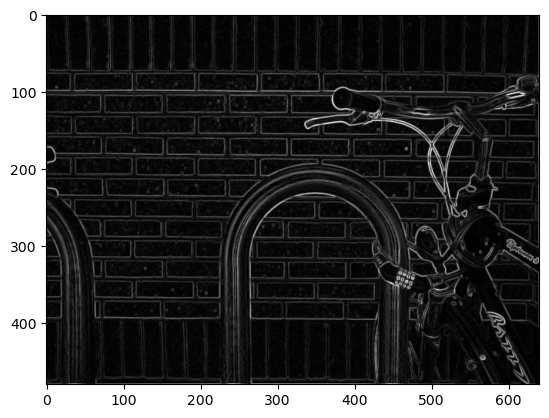

In [14]:
img = cv.imread('../datasets/Bikesgray.jpg', cv.IMREAD_GRAYSCALE)

pwt = prewitt(img)

plt.imshow(pwt, cmap='gray')

In [15]:
def sobel(img, padding=1):
    kernel1 = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    kernel2 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        
    flt = apply_2d_filter(img, kernels=(kernel1, kernel2), padding=padding)
    
    res1, res2 = np.vsplit(flt, 2)
    
    res = np.sqrt(np.square(np.squeeze(res1)) + np.square(np.squeeze(res2)))
    return res.astype(np.uint)

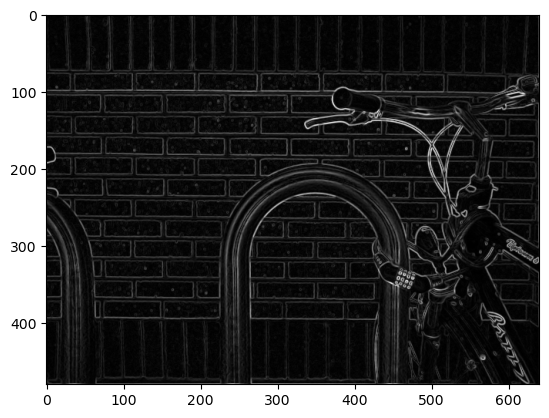

In [16]:
img = cv.imread('../datasets/Bikesgray.jpg', cv.IMREAD_GRAYSCALE)

sbl = sobel(img)

plt.imshow(sbl, cmap='gray')

In [17]:
def laplace(img, padding=1, alpha=1):
    kernel1 = np.array([[1,1,1],[1,-8,1],[1,1,1]])
    
    flt = apply_2d_filter(img, kernels=(kernel1, ), padding=padding)
        
    return np.squeeze(flt)

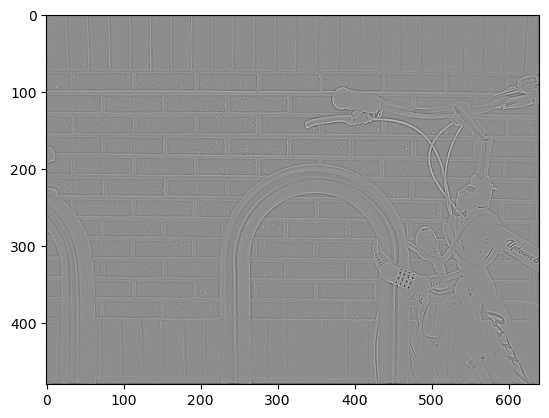

In [18]:
img = cv.imread('../datasets/Bikesgray.jpg', cv.IMREAD_GRAYSCALE)

lpl = laplace(img, alpha=1)

plt.imshow(lpl, cmap='gray')

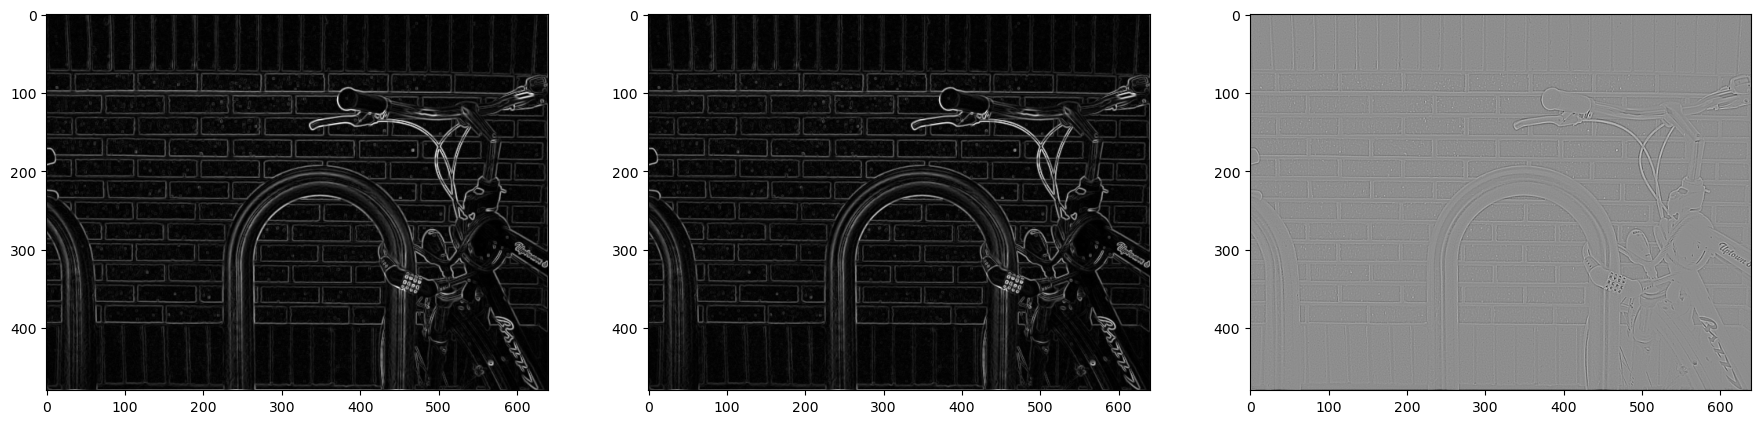

In [19]:
fig, axes = plt.subplots(1,3, figsize=(22,17))

for k, img in enumerate([pwt,sbl,lpl]):
    axes[k].imshow(img, cmap='gray')